## NIPS PLS Spin Test 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-23 17:38:27.137743: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 17:38:28.644933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 17:38:30.901615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *


## Specify connectome and transcriptome

Assign features and targets

In [5]:
# S400
X = load_transcriptome(parcellation='S400', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
Y = Y[valid_indices][:, valid_indices]


## Fit PLS model

5
10
15
20
25


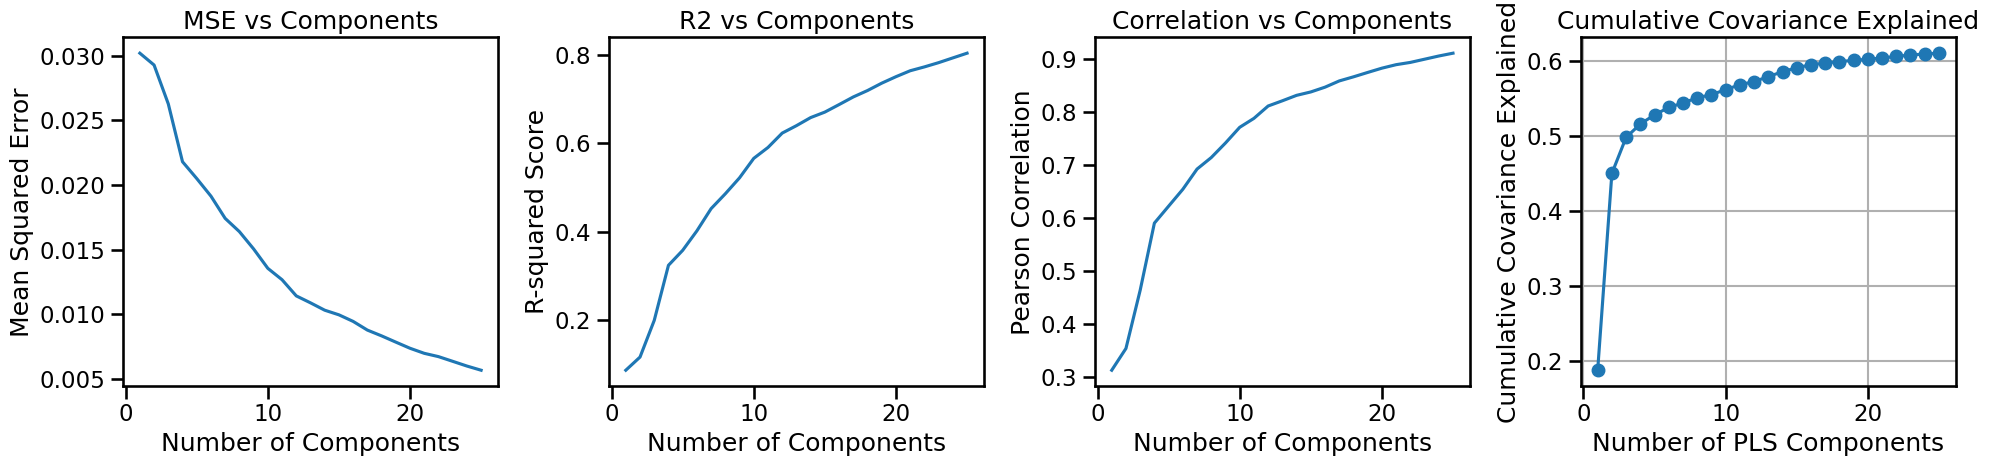

Best model performance (at elbow point):
Number of components: 9
MSE: 0.0151
R2: 0.5219
Mean correlation: 0.7416


In [6]:
def get_best_pls_model(X, Y, max_components=25, use_vertical_elbow=False):
    """
    Evaluate PLS models and return the best one based on correlation score and elbow point.
    
    Args:
        X: Input features array
        Y: Target array
        max_components: Maximum number of components to try
        use_vertical_elbow: Whether to use vertical elbow point lines in plots
        
    Returns:
        PLSRegression: Best performing PLS model
        dict: Dictionary containing performance metrics
    """
    # Initialize lists to store metrics
    mse_scores = []
    r2_scores = []
    corr_scores = []
    covariance_explained = []
    models = []

    # Scale data for covariance calculation
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Compute total covariance between X and Y
    total_covariance = np.sum(np.cov(X_scaled.T, Y_scaled.T, bias=True)[0:len(X_scaled.T), len(X_scaled.T):])

    # Try different numbers of components
    for n_comp in range(1, max_components + 1):
        if n_comp % 5 == 0: 
            print(n_comp)
        
        # Calculate covariance explained
        pls_scaled = PLSRegression(n_components=n_comp)
        pls_scaled.fit(X_scaled, Y_scaled)
        X_scores = pls_scaled.x_scores_
        Y_scores = pls_scaled.y_scores_
        cov_sum = np.sum([np.cov(X_scores[:, i], Y_scores[:, i])[0, 1] for i in range(X_scores.shape[1])])
        covariance_explained.append(cov_sum / total_covariance)

        # refit on unscaled data for predictions in original data space        
        pls = PLSRegression(n_components=n_comp)
        pls.fit(X, Y)
        models.append(pls)
        #models.append(pls_scaled)

        X = X # X_scaled
        Y = Y # Y_scaled
        # Make predictions
        Y_pred = pls.predict(X)
        
        # Calculate metrics
        mse = mean_squared_error(Y, Y_pred)
        r2 = r2_score(Y, Y_pred)
        
        # Calculate Pearson correlation for each connection
        pearson_corr = pearsonr(Y.flatten(), Y_pred.flatten())[0]
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        corr_scores.append(pearson_corr)

    # Find elbow point using kneedle algorithm
    x = np.array(range(1, max_components + 1))
    y = np.array(corr_scores)
    
    # Normalize data for knee detection
    x_normalized = (x - min(x)) / (max(x) - min(x))
    y_normalized = (y - min(y)) / (max(y) - min(y))
    
    # Find knee point
    kn = KneeLocator(x_normalized, y_normalized, curve='concave', direction='increasing')
    elbow_idx = int(kn.knee * max_components) - 1  # Convert back to original scale
    
    # Use elbow point as best model
    best_model = models[elbow_idx]
    
    # Store metrics in dictionary
    metrics = {
        'n_components': elbow_idx + 1,
        'mse': mse_scores[elbow_idx],
        'r2': r2_scores[elbow_idx],
        'correlation': corr_scores[elbow_idx]
    }
    
    # Plot metrics
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].plot(range(1, max_components + 1), mse_scores)
    if use_vertical_elbow:
        axes[0].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].set_title('MSE vs Components')
    if use_vertical_elbow:
        axes[0].legend()

    axes[1].plot(range(1, max_components + 1), r2_scores)
    if use_vertical_elbow:
        axes[1].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('R-squared Score')
    axes[1].set_title('R2 vs Components')
    if use_vertical_elbow:
        axes[1].legend()

    axes[2].plot(range(1, max_components + 1), corr_scores)
    if use_vertical_elbow:
        axes[2].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Pearson Correlation')
    axes[2].set_title('Correlation vs Components')
    if use_vertical_elbow:
        axes[2].legend()

    axes[3].plot(range(1, max_components + 1), covariance_explained, marker='o')
    axes[3].set_xlabel('Number of PLS Components')
    axes[3].set_ylabel('Cumulative Covariance Explained')
    axes[3].set_title('Cumulative Covariance Explained')
    
    # Find elbow point in covariance explained curve
    x = np.array(range(1, max_components + 1))
    y = np.array(covariance_explained)
    x_normalized = (x - min(x)) / (max(x) - min(x))
    y_normalized = (y - min(y)) / (max(y) - min(y))
    kn = KneeLocator(x_normalized, y_normalized, curve='concave', direction='increasing')
    covar_elbow_idx = int(kn.knee * max_components)
    if use_vertical_elbow:
        axes[3].axvline(x=covar_elbow_idx, color='r', linestyle='--', 
                        label=f'Elbow point at {covar_elbow_idx} components')
    
    # Find where 95% threshold is crossed
    threshold_idx = next((i for i, x in enumerate(covariance_explained) if x >= 0.95), None)
    if threshold_idx is not None and use_vertical_elbow:
        axes[3].axvline(x=threshold_idx + 1, color='g', linestyle='--', 
                       label=f'95% reached at {threshold_idx + 1} components')
    
    axes[3].grid(True)
    if use_vertical_elbow:
        axes[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"Best model performance (at elbow point):")
    print(f"Number of components: {metrics['n_components']}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R2: {metrics['r2']:.4f}")
    print(f"Mean correlation: {metrics['correlation']:.4f}")
    
    return best_model, metrics
    
# Get best PLS model
max_components = min(X.shape[1], Y.shape[1]) // 2 # half of max possible components
max_components = 25
best_pls_model, metrics = get_best_pls_model(X, Y, max_components)


In [11]:
# Print dimensionality of PLS parameters
print("PLS Model Parameter Dimensions:")
print("\nWeights:")
print(f"X weights: {best_pls_model.x_weights_.shape} - Left singular vectors of cross-covariance matrices")  
print(f"Y weights: {best_pls_model.y_weights_.shape} - Right singular vectors of cross-covariance matrices")

print("\nLoadings:")
print(f"X loadings: {best_pls_model.x_loadings_.shape} - Loadings/coefficients for X features")
print(f"Y loadings: {best_pls_model.y_loadings_.shape} - Loadings/coefficients for Y targets")

print("\nScores:")
print(f"X scores: {best_pls_model.x_scores_.shape} - Transformed X samples in latent space") 
print(f"Y scores: {best_pls_model.y_scores_.shape} - Transformed Y targets in latent space")

print("\nRotations:")
print(f"X rotations: {best_pls_model.x_rotations_.shape} - Projection matrix for transforming X")
print(f"Y rotations: {best_pls_model.y_rotations_.shape} - Projection matrix for transforming Y")

print("\nCoefficients and Intercepts:")
print(f"Coefficients: {best_pls_model.coef_.shape} - Coefficients for predicting Y from X")
print(f"Intercepts: {best_pls_model.intercept_.shape} - Intercept terms for predictions")


PLS Model Parameter Dimensions:

Weights:
X weights: (7380, 9) - Left singular vectors of cross-covariance matrices
Y weights: (455, 9) - Right singular vectors of cross-covariance matrices

Loadings:
X loadings: (7380, 9) - Loadings/coefficients for X features
Y loadings: (455, 9) - Loadings/coefficients for Y targets

Scores:
X scores: (455, 9) - Transformed X samples in latent space
Y scores: (455, 9) - Transformed Y targets in latent space

Rotations:
X rotations: (7380, 9) - Projection matrix for transforming X
Y rotations: (455, 9) - Projection matrix for transforming Y

Coefficients and Intercepts:
Coefficients: (455, 7380) - Coefficients for predicting Y from X
Intercepts: (455,) - Intercept terms for predictions


In [12]:
print(best_pls_model.n_components)

9


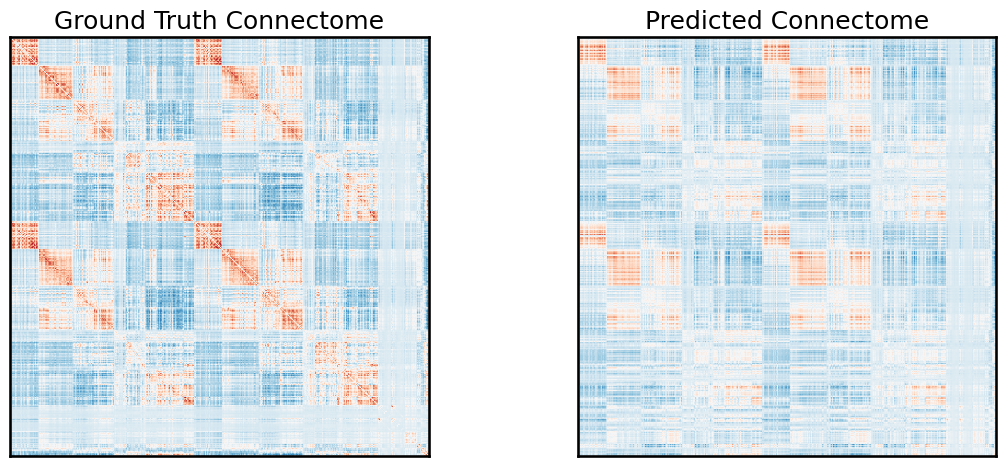

In [13]:
# Get predictions and ground truth
Y_pred = best_pls_model.predict(X)
Y_true = Y

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y_true, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax1.set_title('Ground Truth Connectome')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax2.set_title('Predicted Connectome')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()


### Comparison to null spin tests

In [14]:
spins_df = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df.head()


,cortical_spins,subcortical_spins,cortical_cost,subcortical_cost,total_cost,mean_error_rank,total_cost_rank,SA_error_rank,poly_error_rank,standardized_SA_error,...,SA_lambda_PCA,SA_inf_PCA,poly_a1,poly_a2,poly_a3,poly_a4,poly_a1_PCA,poly_a2_PCA,poly_a3_PCA,poly_a4_PCA
0,"[34, 35, 33, 102, 101, 99, 140, 152, 100, 174,...","[53, 52, 49, 51, 54, 50, 33, 34, 42, 48, 29, 4...",14676.201766,2342.839271,17019.041037,404.000000,665.0,60.0,487.0,2.020939,...,39.069998,-0.164938,0.892056,-0.020372,0.000229,-7.939946e-07,0.892085,-0.026995,0.000288,-1.034092e-06
1,"[31, 33, 135, 171, 162, 154, 35, 98, 158, 101,...","[32, 55, 53, 52, 31, 51, 8, 34, 6, 54, 10, 50,...",14223.071041,3079.720650,17302.791691,871.000000,776.0,925.0,912.0,7.739180,...,18.690197,0.100440,0.895892,-0.017695,0.000150,-3.050474e-07,0.815554,-0.019567,0.000131,-1.852663e-07
2,"[165, 166, 124, 167, 114, 125, 133, 119, 113, ...","[54, 55, 32, 46, 48, 50, 3, 29, 5, 31, 30, 34,...",14066.498745,2193.130687,16259.629432,254.000000,387.0,156.0,219.0,3.187752,...,34.530601,-0.104178,0.990390,-0.023210,0.000244,-7.754920e-07,0.969185,-0.029299,0.000301,-1.024482e-06
3,"[48, 106, 110, 109, 55, 199, 179, 194, 54, 182...","[2, 55, 0, 49, 54, 50, 29, 3, 13, 51, 4, 47, 9...",13520.685713,2364.827011,15885.512724,453.333333,286.0,422.0,652.0,5.352753,...,25.958393,0.007003,0.955965,-0.020002,0.000183,-4.740132e-07,0.908789,-0.023540,0.000193,-4.967189e-07
4,"[185, 184, 64, 86, 87, 63, 85, 187, 61, 58, 56...","[4, 53, 46, 50, 28, 42, 13, 0, 34, 47, 49, 48,...",13896.760066,3108.012640,17004.772706,586.333333,659.0,562.0,538.0,6.010256,...,25.778299,0.011122,0.946094,-0.020804,0.000202,-5.556576e-07,0.959338,-0.027698,0.000260,-7.725980e-07


In [15]:
# Get list of indices to use for each null spin
cortical_spins_list = spins_df['cortical_spins'].tolist()
cortical_spins_list = [eval(x) for x in cortical_spins_list]
cortical_spin_indices = np.array(cortical_spins_list).reshape(1000, 400)
print(cortical_spin_indices.shape)

# Get list of indices to use for each null spin for subcortical regions
subcortical_spins_list = spins_df['subcortical_spins'].tolist()
subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
subcortical_spin_indices = np.array(subcortical_spins_list).reshape(1000, 56)
print(subcortical_spin_indices.shape)

(1000, 400)
(1000, 56)


permutation: 0


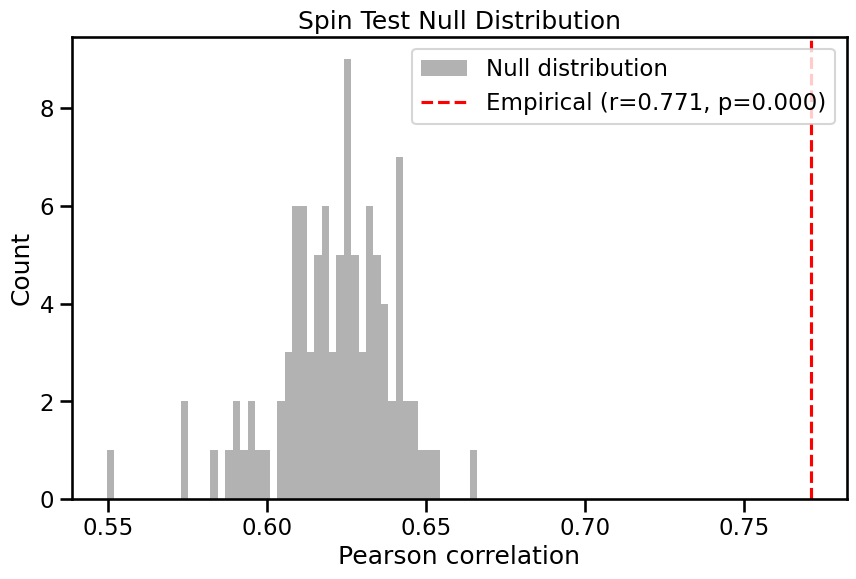

In [ ]:
# Spatial null model
'''
- Idea is that autocorrelation in gene expression, X, may drive the PLS solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data an refit the PLS model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best PLS model as determined by elbow point. 
'''

def run_spin_test_precomputed(X, Y_true, valid_indices, spins_df, n_components, n_perms=1000, sort_spins='mean_error_rank'):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    n_components : int
        Number of PLS components to use
    n_perms : int
        Number of null permutations to run
    shuffle_target : bool
        If True, shuffle connectivity matrix, if False shuffle gene expression
        
    Returns:
    --------
    empirical_corr : float
        Correlation between true and predicted values
    p_value : float
        Spin test p-value 
    null_corrs : array
        Distribution of null correlations
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    best_pls_model = PLSRegression(n_components=n_components)
    best_pls_model.fit(X, Y_true)
    
    # Calculate empirical correlation
    Y_pred_empirical = best_pls_model.predict(X)
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize array for null correlations
    null_corrs = np.zeros(n_perms)
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
            
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit PLS model on rotated data
        null_pls = PLSRegression(n_components=n_components)
        null_pls.fit(X_rotated, Y_rotated)
        
        # Get predictions and calculate correlation
        Y_pred_null = null_pls.predict(X_rotated)
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Example usage:
empirical_corr, p_value, null_distribution = run_spin_test_precomputed(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y_true, 
    spins_df=spins_df,
    sort_spins='mean_error_rank',
    n_components=10,
    n_perms=100
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


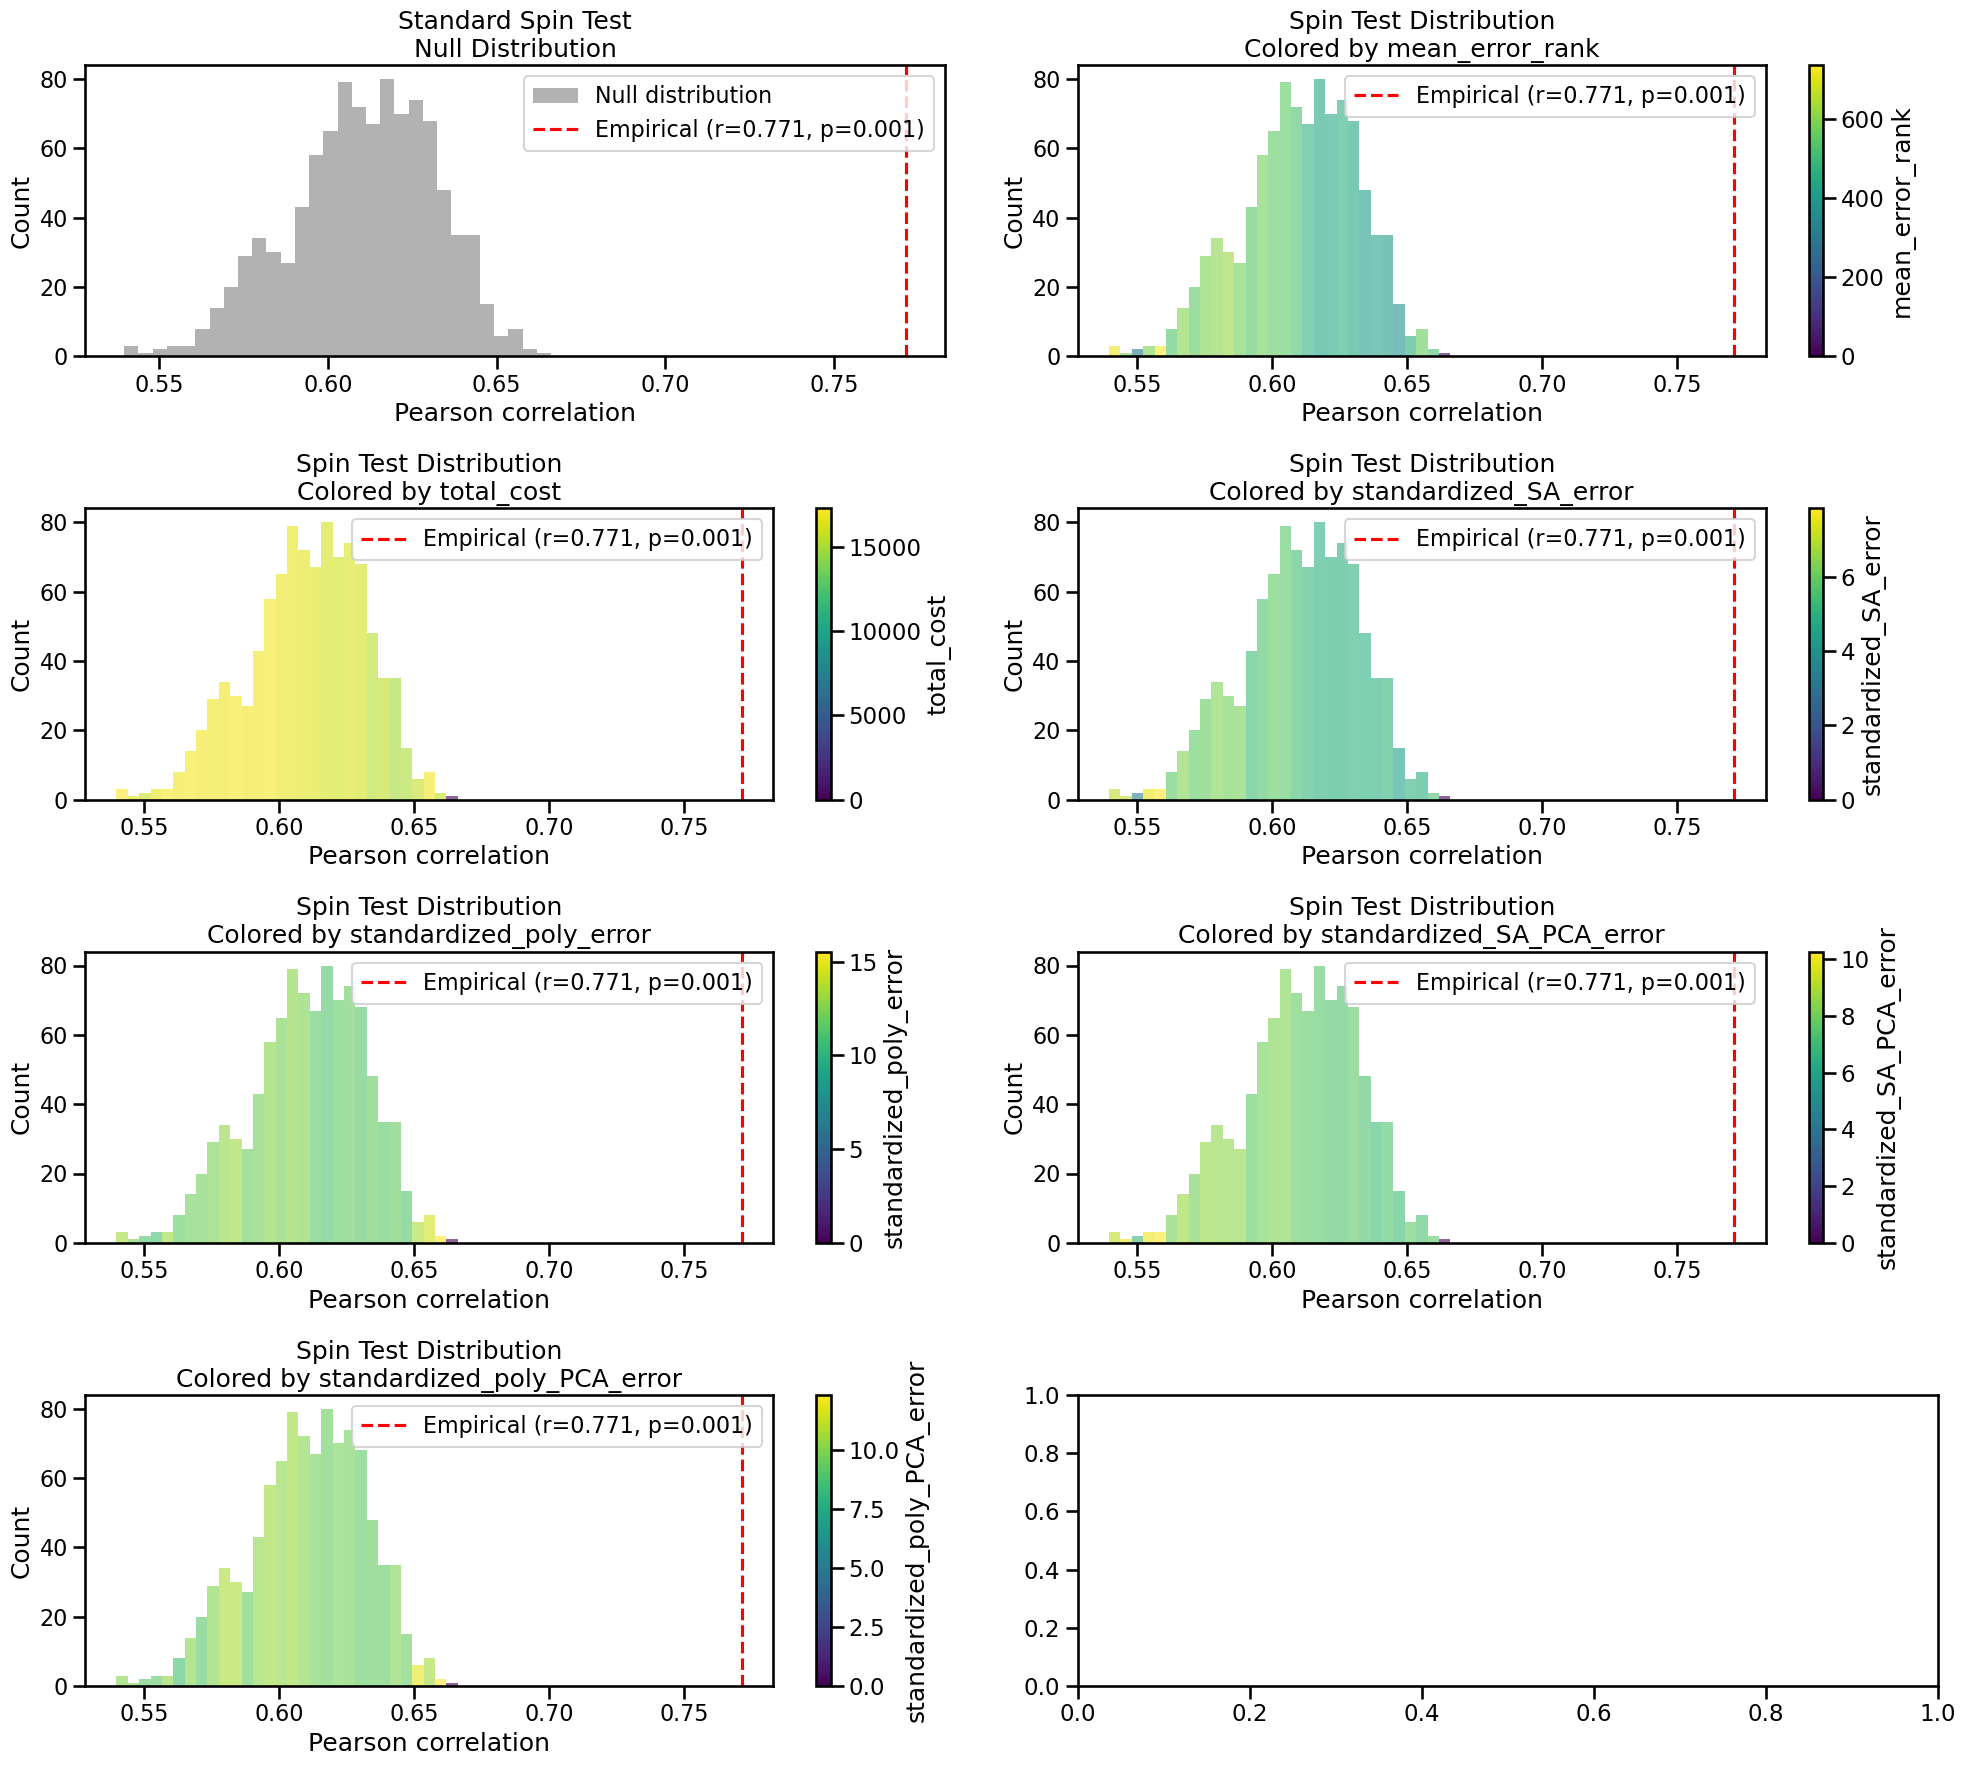

In [23]:
def run_spin_test_precomputed_colored(X, Y_true, valid_indices, spins_df, n_components, n_perms=1000, sort_spins='mean_error_rank', bins=25, fontsize=18):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    n_components : int
        Number of PLS components to use
    n_perms : int
        Number of null permutations to run
    sort_spins : str
        Metric to sort spins by
    fontsize : int
        Font size for plot text elements
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    best_pls_model = PLSRegression(n_components=n_components)
    best_pls_model.fit(X, Y_true)
    
    # Calculate empirical correlation
    Y_pred_empirical = best_pls_model.predict(X)
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize arrays for null correlations and error metrics
    null_corrs = np.zeros(n_perms)
    error_metrics = {
        'mean_error_rank': np.zeros(n_perms),
        'total_cost': np.zeros(n_perms),
        'standardized_SA_error': np.zeros(n_perms),
        'standardized_poly_error': np.zeros(n_perms),
        'standardized_SA_PCA_error': np.zeros(n_perms),
        'standardized_poly_PCA_error': np.zeros(n_perms)
    }
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
          
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Store error metrics for this permutation
        for metric in error_metrics.keys():
            error_metrics[metric][i] = spins_df[metric].iloc[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit PLS model on rotated data
        null_pls = PLSRegression(n_components=n_components)
        null_pls.fit(X_rotated, Y_rotated)
        
        # Get predictions and calculate correlation
        Y_pred_null = null_pls.predict(X_rotated)
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = max(1/(n_perms + 1), np.mean(null_corrs >= empirical_corr))

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten for easier indexing
    
    # Plot 1: Standard uncolored histogram
    axes[0].hist(null_corrs, bins=bins, alpha=0.6, color='gray', label='Null distribution')
    axes[0].axvline(empirical_corr, color='red', linestyle='--', 
                    label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    axes[0].set_xlabel('Pearson correlation', fontsize=fontsize)
    axes[0].set_ylabel('Count', fontsize=fontsize)
    axes[0].set_title('Standard Spin Test\nNull Distribution', fontsize=fontsize)
    axes[0].legend(fontsize=fontsize-2)
    axes[0].tick_params(labelsize=fontsize-2)
    
    # Calculate bin edges and centers once
    counts, bin_edges = np.histogram(null_corrs, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot colored histograms for each error metric
    for idx, (metric, values) in enumerate(error_metrics.items(), 1):
        # Calculate mean error metric for each bin
        bin_errors = np.zeros(len(bin_centers))
        for i in range(len(bin_centers)):
            mask = (null_corrs >= bin_edges[i]) & (null_corrs < bin_edges[i+1])
            bin_errors[i] = np.mean(values[mask]) if np.any(mask) else 0
        
        # Create colored histogram with darker colors for lower values
        norm = plt.Normalize(bin_errors.min(), bin_errors.max())
        colors = plt.cm.viridis(norm(bin_errors))  # Using reversed colormap
        
        # Plot bars
        bars = axes[idx].bar(bin_centers, counts, width=np.diff(bin_edges), 
                            color=colors, alpha=0.6)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        plt.colorbar(sm, ax=axes[idx], label=metric)
        
        # Add empirical line
        axes[idx].axvline(empirical_corr, color='red', linestyle='--',
                         label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
        
        axes[idx].set_xlabel('Pearson correlation', fontsize=fontsize)
        axes[idx].set_ylabel('Count', fontsize=fontsize)
        axes[idx].set_title(f'Spin Test Distribution\nColored by {metric}', fontsize=fontsize)
        axes[idx].legend(fontsize=fontsize-2)
        axes[idx].tick_params(labelsize=fontsize-2)
    
    plt.tight_layout()
    plt.show()
    
    return empirical_corr, p_value, null_corrs, error_metrics

# Example usage:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y_true, 
    spins_df=spins_df,
    sort_spins='mean_error_rank',
    n_components=10,
    n_perms=1000,
    bins=30
)

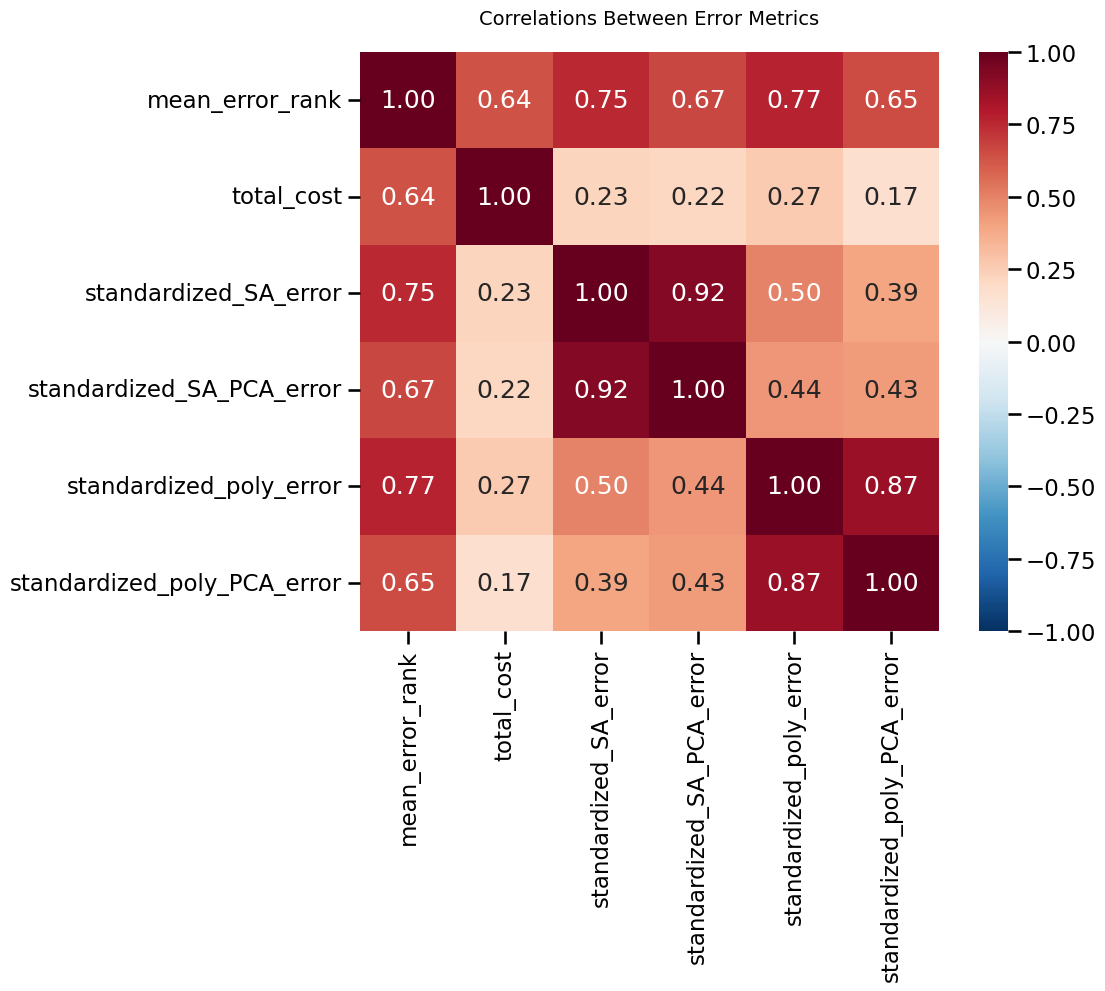

In [24]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


